In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)

def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)




def a(t): # as per RD
    return np.sqrt(2 * H_0 * t)

def V_shell(r1, r2):
    return (4 * π / 3) * (r2**3 - r1**3)




def rho_DM(a):
    return 0.85 * (ρ_m0 * (a**-3))  



def rho_background(r, a):
    return rho_DM(a) * (4/3) * np.pi * (r**3) 



def fdm_EOM(t, y, j):
    r, v = y 
    #print(delta_M[0])
    M_enclosed_total = M_pbh #+  np.sum(delta_M[:j+1])  
    dv_G_dt = -(G * M_enclosed_total)/(r**2)  # G.P.due to PBH only
    dv_QP_dt = QP_arr[j] 
    H_t = 1/(2*t)  # with H(t) = 1/2t in RD
    dv_H_dt = -(H_t*v)  #-ri_arr[j]/(4 * (t**2)) 
    return [v, dv_G_dt + dv_QP_dt + dv_H_dt ]




delta_M_arr =  [1.06513583e+09 1.05448447e+11 1.05448447e+13 1.05448447e+15
 1.05448447e+17 1.05448447e+19 1.05448447e+21]
rho_arr = [2.54282448e+32 2.54282448e+32 2.54282448e+32 2.54282448e+32
 2.54282448e+32 2.54282448e+32]


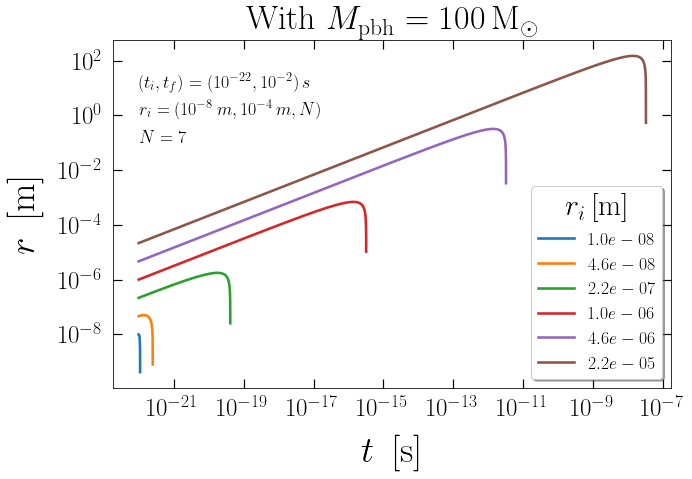

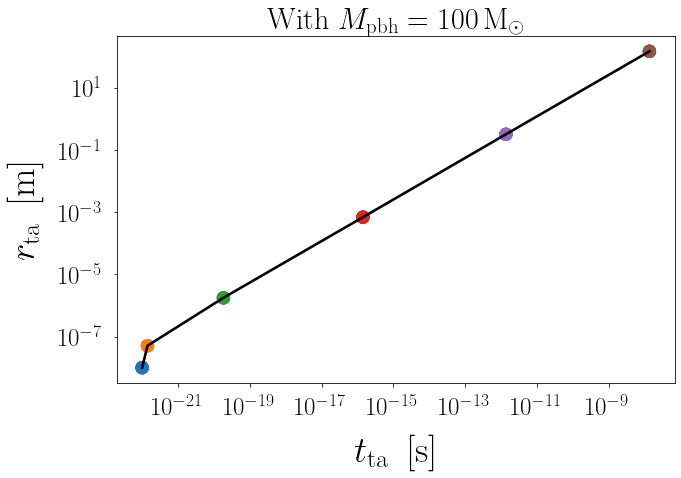

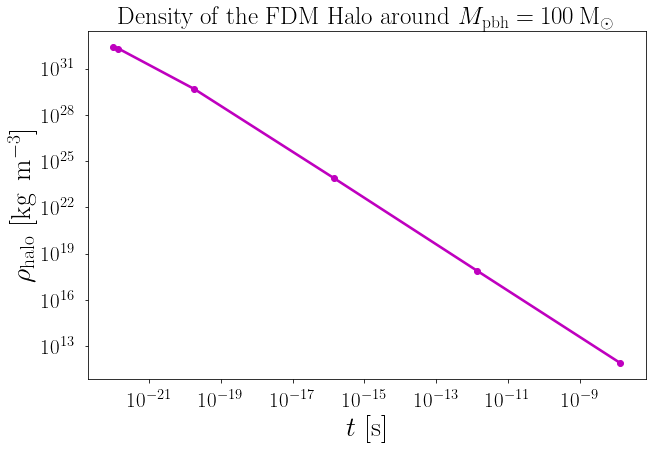

r_i:1.0000e-08 m, r_ta:1.0009e-08 m, t_ta:1.0038e-22 s
r_i:4.6416e-08 m, r_ta:5.0659e-08 m, t_ta:1.4108e-22 s
r_i:2.1544e-07 m, r_ta:1.7648e-06 m, t_ta:1.8487e-20 s
r_i:1.0000e-06 m, r_ta:6.8788e-04 m, t_ta:1.4204e-16 s
r_i:4.6416e-06 m, r_ta:3.1872e-01 m, t_ta:1.3686e-12 s
r_i:2.1544e-05 m, r_ta:1.4793e+02 m, t_ta:1.3684e-08 s


In [2]:
t_i = 1e-22
t_f = 1e-2 
t_arr = np.geomspace(t_i, t_f, 100000)  


ri_arr = np.geomspace(1e-8, 1e-4, 7)  


a_i = a(t_i)
rho_arr = np.zeros(len(ri_arr) - 1)
delta_M_arr = np.zeros(len(ri_arr))
for j in range(len(ri_arr) - 1): 
    if j == 0:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(0, ri_arr[j]) 
        rho_arr[j] = rho_DM(a_i)
    else:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(ri_arr[j-1], ri_arr[j])  
        V_j = V_shell(ri_arr[j-1], ri_arr[j])  
        rho_arr[j] = delta_M_arr[j] / V_j  
delta_M_arr[-1] = rho_DM(a_i) * V_shell(ri_arr[-2], ri_arr[-1])  


print("delta_M_arr = " , delta_M_arr)
print("rho_arr =", rho_arr)


grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

QP_arr = np.zeros_like(rho_arr)
for j in range(len(rho_arr)):
    if rho_arr[j] > 0:
        QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
    else:
        QP_arr[j] = 0  


M_pbh = 100 * M_solar  
r_ta_arr = []
t_ta_arr = []




fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

colors = [ 'C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for j in range(len(ri_arr) - 1):  
    r0 = [ri_arr[j], ri_arr[j]/(2 * t_i)] 
    sol = solve_ivp(fdm_EOM, [t_i, t_f], r0, t_eval=t_arr, method='RK45', args=(j,),
                    events=[event_y_max, event_y_min], atol=1e-5, rtol=1e-5)
    ax1.loglog(sol.t, sol.y[0], label=f"${ri_arr[j]:.1e}$", color=colors[j])
    if len(sol.t_events[0]) > 0: 
        t_ta_arr.append(sol.t_events[0][0])
        r_ta_arr.append(sol.y_events[0][0][0])


        
plt.text(1e-22, 10, '$(t_i, t_f) = (10^{-22}, 10^{-2})\,s $', fontsize = 18)
plt.text(1e-22, 1, '$r_i = (10^{-8}\,m, 10^{-4}\,m, N) $', fontsize = 18)
plt.text(1e-22, 0.1, '$N = 7 $', fontsize = 18)

        
        
ax1.tick_params(axis='x', pad=9.9)
ax1.tick_params(axis='y', pad=9.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)

plt.legend(prop = {'size':17.8}, loc = 'lower right',
           shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3.pdf', bbox_inches = 'tight')
plt.show()



fig, ax2 = plt.subplots(figsize=(10, 6.4))
for i, color in enumerate(colors): 
    ax2.scatter(t_ta_arr, r_ta_arr, color = colors,  s = 150)

ax2.loglog(t_ta_arr, r_ta_arr,  color = 'k')

ax2.tick_params(axis='x', pad=9.9)
ax2.tick_params(axis='y', pad=9.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t.pdf', bbox_inches = 'tight')
plt.show()

rho_halo_arr = np.zeros(len(t_ta_arr))   
for i in range(len(r_ta_arr)):
    N_shells = i + 1  
    M_halo = np.sum(delta_M_arr[:N_shells])  
    V_outer = (4 / 3) * np.pi * (r_ta_arr[i]**3)  
    rho_halo_arr[i] = M_halo / V_outer  


fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.loglog(t_ta_arr, rho_halo_arr, 'o-', color='m')
ax3.tick_params(axis='x', pad=9.9)
ax3.tick_params(axis='y', pad=9.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t.pdf', bbox_inches = 'tight')
plt.show()


for ri, r, t in zip(ri_arr, r_ta_arr, t_ta_arr):
    print(f"r_i:{ri:.4e} m, r_ta:{r:.4e} m, t_ta:{t:.4e} s")

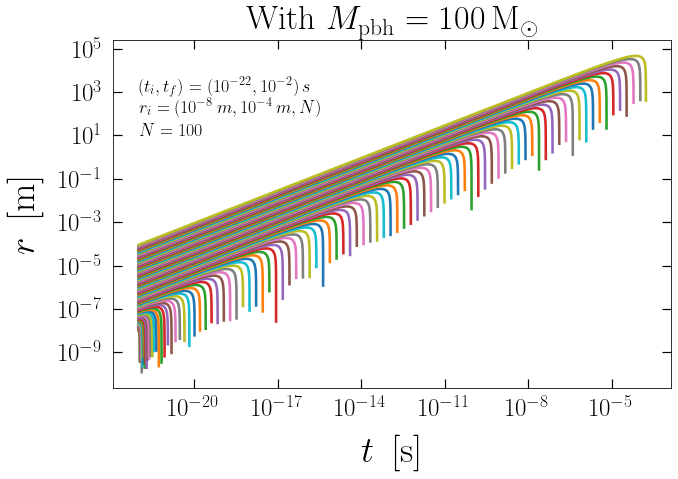

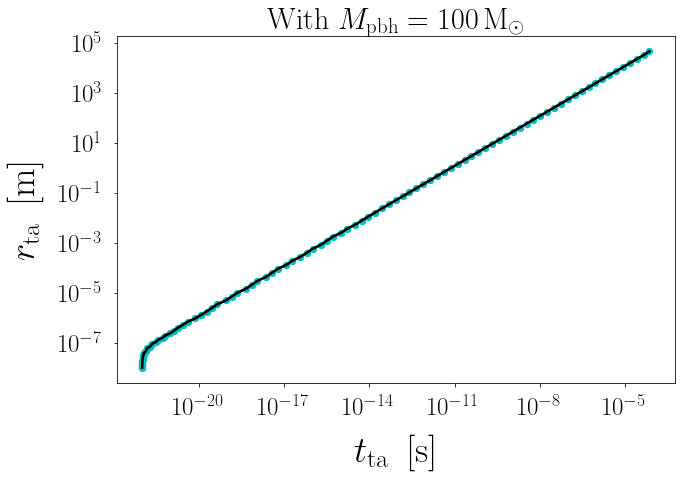

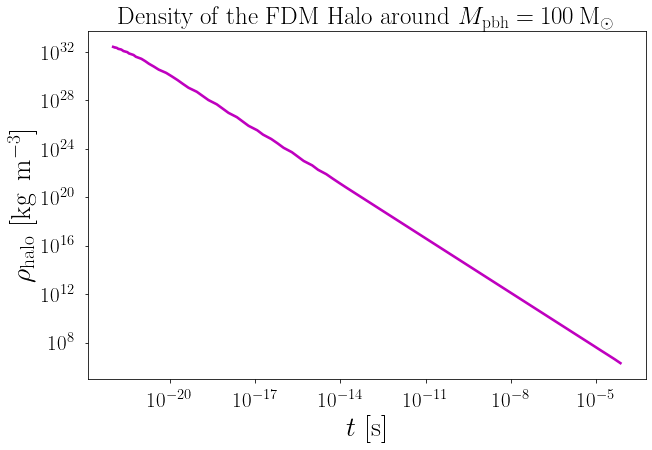

In [3]:
t_i = 1e-22
t_f = 1e-2 
t_arr = np.geomspace(t_i, t_f, 100000)  


ri_arr = np.geomspace(1e-8, 1e-4, 100)  


a_i = a(t_i)
rho_arr = np.zeros(len(ri_arr) - 1)
delta_M_arr = np.zeros(len(ri_arr))
for j in range(len(ri_arr) - 1): 
    if j == 0:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(0, ri_arr[j]) 
        rho_arr[j] = rho_DM(a_i)
    else:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(ri_arr[j-1], ri_arr[j])  
        V_j = V_shell(ri_arr[j-1], ri_arr[j])  
        rho_arr[j] = delta_M_arr[j] / V_j  
delta_M_arr[-1] = rho_DM(a_i) * V_shell(ri_arr[-2], ri_arr[-1])  


#print("delta_M_arr = " , delta_M_arr)
#print("rho_arr =", rho_arr)


grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

QP_arr = np.zeros_like(rho_arr)
for j in range(len(rho_arr)):
    if rho_arr[j] > 0:
        QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
    else:
        QP_arr[j] = 0  


M_pbh = 100 * M_solar  
r_ta_arr = []
t_ta_arr = []




fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

colors = [ 'C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for j in range(len(ri_arr) - 1):  
    r0 = [ri_arr[j], ri_arr[j]/(2 * t_i)] 
    sol = solve_ivp(fdm_EOM, [t_i, t_f], r0, t_eval=t_arr, method='RK45', args=(j,),
                    events=[event_y_max, event_y_min], atol=1e-5, rtol=1e-5)
    ax1.loglog(sol.t, sol.y[0], label=f"${ri_arr[j]:.1e}$")
    if len(sol.t_events[0]) > 0: 
        t_ta_arr.append(sol.t_events[0][0])
        r_ta_arr.append(sol.y_events[0][0][0])


        
plt.text(1e-22, 1000, '$(t_i, t_f) = (10^{-22}, 10^{-2})\,s $', fontsize = 18)
plt.text(1e-22, 100, '$r_i = (10^{-8}\,m, 10^{-4}\,m, N) $', fontsize = 18)
plt.text(1e-22, 10, '$N = 100 $', fontsize = 18)

        
        
ax1.tick_params(axis='x', pad=9.9)
ax1.tick_params(axis='y', pad=9.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
#plt.legend(prop = {'size':17.8}, loc = 'lower right',
          # shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           #facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3_1.pdf', bbox_inches = 'tight')
plt.show()



fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color='c', s= 40)
ax2.loglog(t_ta_arr, r_ta_arr, color='k')

ax2.tick_params(axis='x', pad=9.9)
ax2.tick_params(axis='y', pad=9.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t1.pdf', bbox_inches = 'tight')
plt.show()

rho_halo_arr = np.zeros(len(t_ta_arr))   
for i in range(len(r_ta_arr)):
    N_shells = i + 1  
    M_halo = np.sum(delta_M_arr[:N_shells])  
    V_outer = (4 / 3) * np.pi * (r_ta_arr[i]**3)  
    rho_halo_arr[i] = M_halo / V_outer 


fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.loglog(t_ta_arr, rho_halo_arr,  color='m')
ax3.tick_params(axis='x', pad=9.9)
ax3.tick_params(axis='y', pad=9.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t1.pdf', bbox_inches = 'tight')
plt.show()



#for ri, r, t in zip(ri_arr, r_ta_arr, t_ta_arr):
   # print(f"r_i:{ri:.4e} m, r_ta:{r:.4e} m, t_ta:{t:.4e} s")

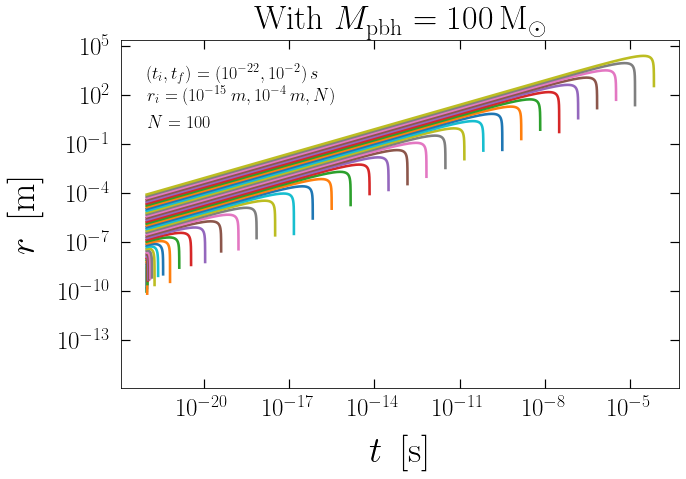

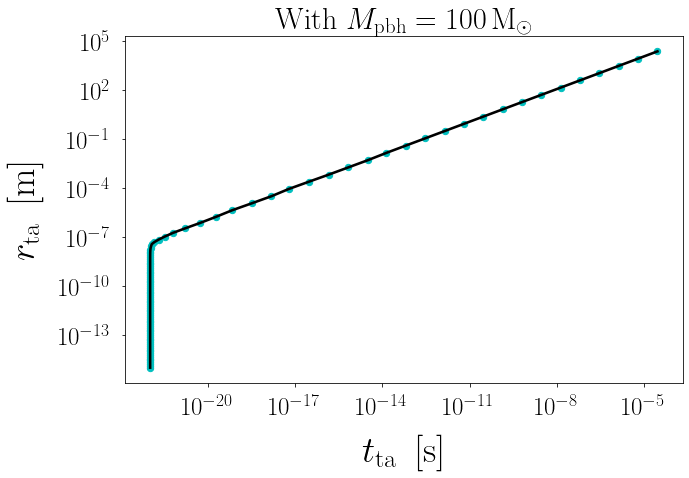

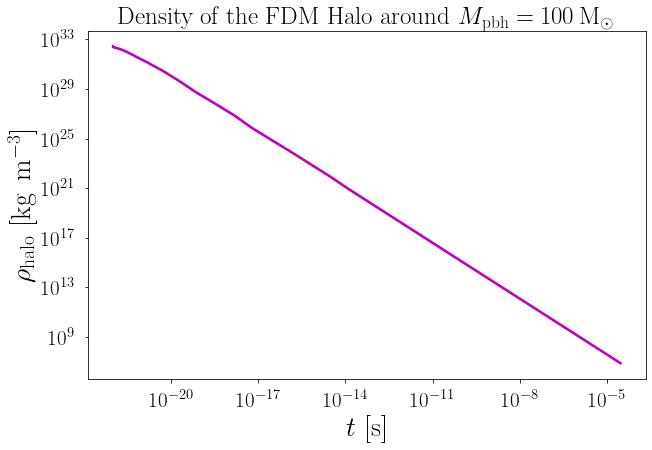

In [4]:
t_i = 1e-22
t_f = 1e-2 
t_arr = np.geomspace(t_i, t_f, 100000)  


ri_arr = np.geomspace(1e-15, 1e-4, 100)  


a_i = a(t_i)
rho_arr = np.zeros(len(ri_arr) - 1)
delta_M_arr = np.zeros(len(ri_arr))
for j in range(len(ri_arr) - 1): 
    if j == 0:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(0, ri_arr[j]) 
        rho_arr[j] = rho_DM(a_i)
    else:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(ri_arr[j-1], ri_arr[j])  
        V_j = V_shell(ri_arr[j-1], ri_arr[j])  
        rho_arr[j] = delta_M_arr[j] / V_j  
delta_M_arr[-1] = rho_DM(a_i) * V_shell(ri_arr[-2], ri_arr[-1])  


#print("delta_M_arr = " , delta_M_arr)
#print("rho_arr =", rho_arr)


grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

QP_arr = np.zeros_like(rho_arr)
for j in range(len(rho_arr)):
    if rho_arr[j] > 0:
        QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
    else:
        QP_arr[j] = 0  


M_pbh = 100 * M_solar  
r_ta_arr = []
t_ta_arr = []




fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

colors = [ 'C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for j in range(len(ri_arr) - 1):  
    r0 = [ri_arr[j], ri_arr[j]/(2 * t_i)] 
    sol = solve_ivp(fdm_EOM, [t_i, t_f], r0, t_eval=t_arr, method='RK45', args=(j,),
                    events=[event_y_max, event_y_min], atol=1e-5, rtol=1e-5)
    ax1.loglog(sol.t, sol.y[0], label=f"${ri_arr[j]:.1e}$")
    if len(sol.t_events[0]) > 0: 
        t_ta_arr.append(sol.t_events[0][0])
        r_ta_arr.append(sol.y_events[0][0][0])


        
        
plt.text(1e-22, 1000, '$(t_i, t_f) = (10^{-22}, 10^{-2})\,s $', fontsize = 18)
plt.text(1e-22, 40, '$r_i = (10^{-15}\,m, 10^{-4}\,m, N) $', fontsize = 18)
plt.text(1e-22, 1, '$N = 100 $', fontsize = 18)

        
        
ax1.tick_params(axis='x', pad=9.9)
ax1.tick_params(axis='y', pad=9.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
#plt.legend(prop = {'size':17.8}, loc = 'lower right',
          # shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           #facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3_2.pdf', bbox_inches = 'tight')
plt.show()



fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color='c', s= 40)
ax2.loglog(t_ta_arr, r_ta_arr, color='k')

ax2.tick_params(axis='x', pad=9.9)
ax2.tick_params(axis='y', pad=9.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t2.pdf', bbox_inches = 'tight')
plt.show()

rho_halo_arr = np.zeros(len(t_ta_arr))   
for i in range(len(r_ta_arr)):
    N_shells = i + 1  
    M_halo = np.sum(delta_M_arr[:N_shells])  
    V_outer = (4 / 3) * np.pi * (r_ta_arr[i]**3)  
    rho_halo_arr[i] = M_halo / V_outer 


fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.loglog(t_ta_arr, rho_halo_arr,  color='m')
ax3.tick_params(axis='x', pad=9.9)
ax3.tick_params(axis='y', pad=9.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t2.pdf', bbox_inches = 'tight')
plt.show()



#for ri, r, t in zip(ri_arr, r_ta_arr, t_ta_arr):
   # print(f"r_i:{ri:.4e} m, r_ta:{r:.4e} m, t_ta:{t:.4e} s")

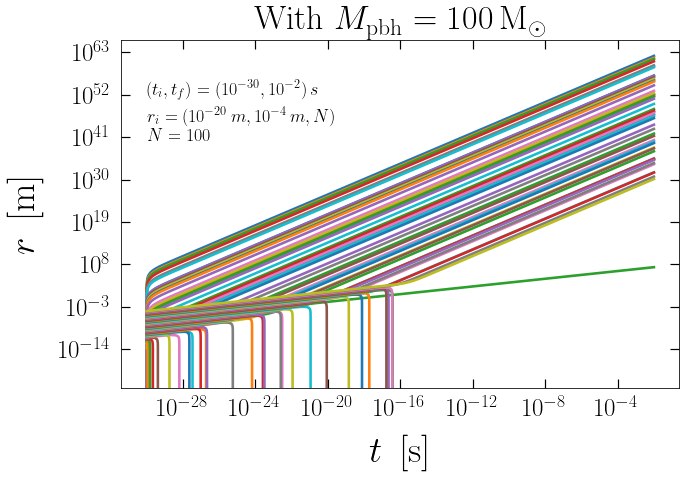

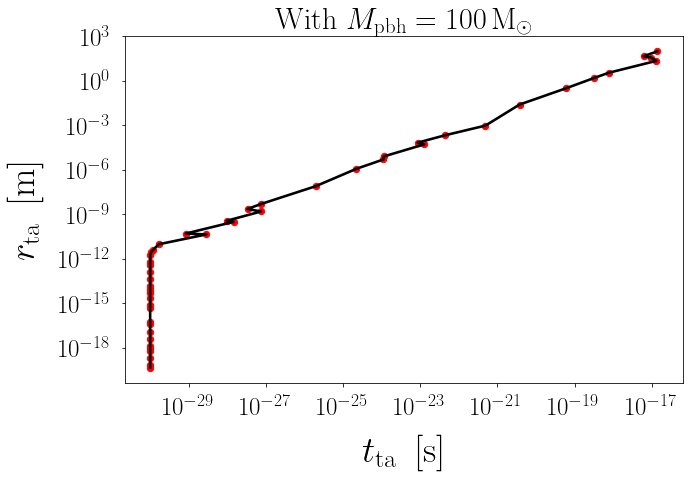

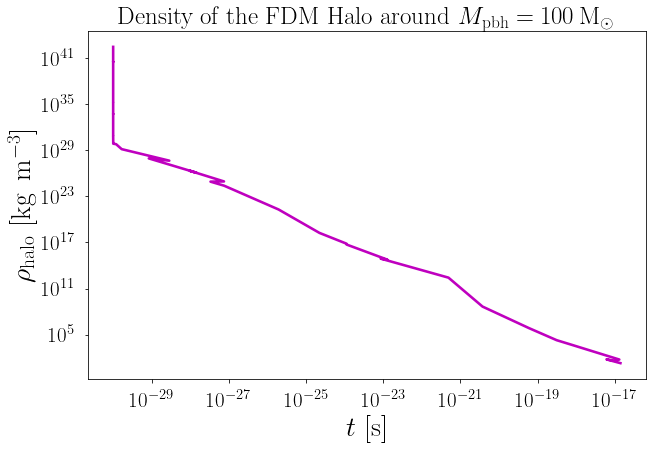

In [5]:
t_i = 1e-30
t_f = 1e-2 
t_arr = np.geomspace(t_i, t_f, 100000)  


ri_arr = np.geomspace(1e-20, 1e-4, 100)  


a_i = a(t_i)
rho_arr = np.zeros(len(ri_arr) - 1)
delta_M_arr = np.zeros(len(ri_arr))
for j in range(len(ri_arr) - 1): 
    if j == 0:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(0, ri_arr[j]) 
        rho_arr[j] = rho_DM(a_i)
    else:
        delta_M_arr[j] = rho_DM(a_i) * V_shell(ri_arr[j-1], ri_arr[j])  
        V_j = V_shell(ri_arr[j-1], ri_arr[j])  
        rho_arr[j] = delta_M_arr[j] / V_j  
delta_M_arr[-1] = rho_DM(a_i) * V_shell(ri_arr[-2], ri_arr[-1])  


#print("delta_M_arr = " , delta_M_arr)
#print("rho_arr =", rho_arr)


grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

QP_arr = np.zeros_like(rho_arr)
for j in range(len(rho_arr)):
    if rho_arr[j] > 0:
        QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
    else:
        QP_arr[j] = 0  


M_pbh = 100 * M_solar  
r_ta_arr = []
t_ta_arr = []




fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

colors = [ 'C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for j in range(len(ri_arr) - 1):  
    r0 = [ri_arr[j], ri_arr[j]/(2 * t_i)] 
    sol = solve_ivp(fdm_EOM, [t_i, t_f], r0, t_eval=t_arr, method='RK45', args=(j,),
                    events=[event_y_max, event_y_min], atol=1e-5, rtol=1e-5)
    ax1.loglog(sol.t, sol.y[0], label=f"${ri_arr[j]:.1e}$")
    if len(sol.t_events[0]) > 0: 
        t_ta_arr.append(sol.t_events[0][0])
        r_ta_arr.append(sol.y_events[0][0][0])


        
plt.text(t_i, 1e52, '$(t_i, t_f) = (10^{-30}, 10^{-2})\,s $', fontsize = 18)
plt.text(t_i, 1e45, '$r_i = (10^{-20}\,m, 10^{-4}\,m, N) $', fontsize = 18)
plt.text(t_i, 1e40, '$N = 100 $', fontsize = 18)

 
        
        
ax1.tick_params(axis='x', pad=9.9)
ax1.tick_params(axis='y', pad=9.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
#plt.legend(prop = {'size':17.8}, loc = 'lower right',
          # shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           #facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3_3.pdf', bbox_inches = 'tight')
plt.show()



fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color='r', s= 40)
ax2.loglog(t_ta_arr, r_ta_arr, color='k')

ax2.tick_params(axis='x', pad=9.9)
ax2.tick_params(axis='y', pad=9.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t3.pdf', bbox_inches = 'tight')
plt.show()


rho_halo_arr = np.zeros(len(t_ta_arr))   
for i in range(len(r_ta_arr)):
    N_shells = i + 1  
    M_halo = np.sum(delta_M_arr[:N_shells])  
    V_outer = (4 / 3) * np.pi * (r_ta_arr[i]**3)  
    rho_halo_arr[i] = M_halo / V_outer 


fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.loglog(t_ta_arr, rho_halo_arr,  color='m')
ax3.tick_params(axis='x', pad=9.9)
ax3.tick_params(axis='y', pad=9.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t3.pdf', bbox_inches = 'tight')
plt.show()



#for ri, r, t in zip(ri_arr, r_ta_arr, t_ta_arr):
   # print(f"r_i:{ri:.4e} m, r_ta:{r:.4e} m, t_ta:{t:.4e} s")